# Estimation of probability density function

## This script contains the following

* Estimation of the probability densitity function using the surrogate-NL

## Problem description
Consider the linear-nonlinear coupled problem with non-linear diffusion as in (1.3). Let the output of interest be given by the average value on domain $\Omega_2$, that is

\begin{align}
\label{eq:avg2}
    F(u({x};{\mu})) &= \frac{1}{|\Omega_2|} \int_{\Omega_2} u({x};{\mu}) \ d\Omega_2 \\
         &\approx \frac{1}{N_2} \sum_{i=1}^{N_2} U_{2}^{rb,(i)},
\end{align}

which is approximated by the average value of the elements of the vector ${U}_2^{rb}$. Suppose the quantity of interest is given by the expectation, that is

\begin{align}
\label{eq:qoireaction}
    \mathbb{E}[F] = \int_\mathcal{P} F(u({x};{\mu}))\rho({\mu}) \ d{\mu}. 
\end{align}

We aim to approximate the probability density function (PDF) of $E[F]$ using the
surrogate-NL.

# Import libraries and load functions

In [1]:
%run functions.ipynb

# Offline stage

# Create FOM snapshots

In [15]:
# Choose number of snapshots and test samples
ntest = 0
nsamples = 500 + ntest

# Boolean alreadyrun 
# 1 if the variables are already computed
# 0 else

alreadyrun = 1

if not alreadyrun:
    %run FOM_snapshots.ipynb

    # Open a file and use dump()
    variables = [S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train, m3_time_onl]

    with open('offline_vars.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
        
else:   
    with open('offline_vars.pkl', 'rb') as file:

        # Call load method
        S, S1, SI, S2, A_I1_array, A_1I_array, A_11_array, A_II1_array, F_1_array, mu,  F_1_array, F_1I_array, snapshots_time, m3_time_train = pickle.load(file)

# Perform POD analysis

Snapshot energy domain 1: 0.9666179772016339
Snapshot energy domain 2: 0.9901551696750418
Snapshot energy interface: 0.9819837091583478


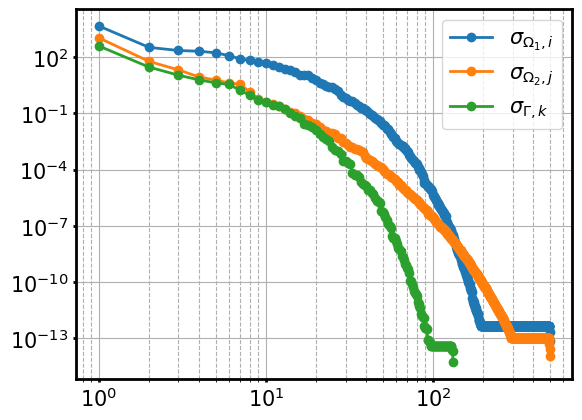

In [16]:
# Choose the number of modes in reduced-order spaces
cutoff1 = 10
cutoffI = 5
cutoff2 = 5

V_1, V_I, V_2, ndofs_u1, ndofs_uI, ndofs_u2, u1, uI, u2 = POD_all(S1, SI, S2, cutoff1, cutoffI, cutoff2)

# Train separate neural networks $\hat{\pi}^{(i)}_2$ for $i=1,2,...,n_2$

In [20]:
alreadyrun = 1

if not alreadyrun:
    start = time.time()
    
    nmodes = 1
    n_epochs = 1000
    learning_rate = 0.1
    torch_inputs = torch.from_numpy(np.column_stack((uI[0:nsamples-ntest], mu[0:nsamples-ntest,4]))).float()

    u_2_models34 = []

    for i in range(int(cutoff2/nmodes)):
        if i == 1:
            learning_rate = 0.01
        if i == 6:
            n_epochs = 500

        torch_outputs = torch.from_numpy(u2[0:nsamples-ntest,i*nmodes:i*nmodes+nmodes]).float()
        
        print("Training a Neural Network for mode",i*nmodes+1,"on domain 2...")
        u_2_model, NN2time, loss = Neural_Network_small(torch_inputs, torch_outputs, n_epochs, learning_rate)

        u_2_models34.append(u_2_model)
        
    end = time.time()
    time_u2_34 = end-start
    
    # Open a file and use dump()
    variables = [u_2_models34, time_u2_34]

    with open('u_2_models34.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('u_2_models34.pkl', 'rb') as file:

        # Call load method
        u_2_models34, time_u2_34 = pickle.load(file)

# Train neural network for $\hat{\pi}_\Gamma$

In [ ]:
alreadyrun = 1

if not alreadyrun:

    torch_inputs = torch.from_numpy(mu_all[0:nsamples-ntest,:]).float()
    n_epochs = 1000
    learning_rate = 0.001

    torch_outputs = torch.from_numpy(uI[0:nsamples-ntest,:]).float()

    uI_model4, uI_model4time, loss = Neural_Network(torch_inputs, torch_outputs, n_epochs, learning_rate)
    
    variables = [uI_model4, uI_model4time]


    with open('ugamma4.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
else:   
    with open('ugamma4.pkl', 'rb') as file:

        # Call load method
        uI_model4, uI_model4time = pickle.load(file)

# Load Monte Carlo samples

In [18]:
alreadyrun = 1
nsamples = 1000 

if not alreadyrun:

    %run MC_simulations.ipynb
    
    variables = [S2, mu]
    
    with open('MC_variables.pkl', 'wb') as file:

        # create new file
        pickle.dump(variables, file)
    
else:
    with open('MC_variables.pkl', 'rb') as file:

        # Call load method
        S2, mu = pickle.load(file)

# Histogram of the monte Carlo simulation

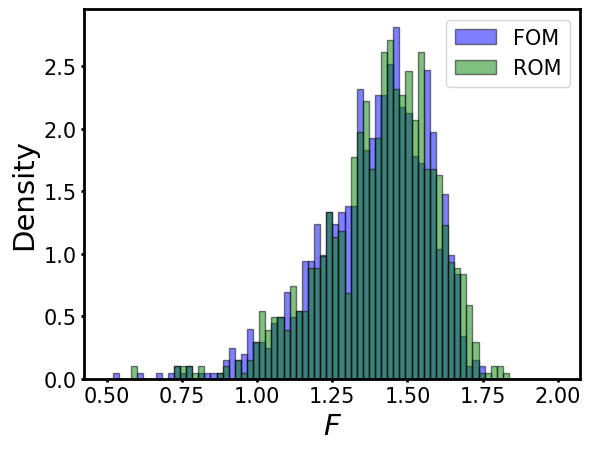

In [21]:
# Initialize output of interest
OoI_array_FOM = np.zeros((nsamples))
OoI_array_ROM = np.zeros((nsamples))

nmodes = 1

for j in range(nsamples):
    OoI_FOM = np.mean(S2[:,j])
    OoI_array_FOM[j] = OoI_FOM
    
    which = j
    mu_test = mu[which]
        
    u_I_pred_m4 = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()
    u_I_predh_m4 = np.matmul(V_I,u_I_pred_m4)
    u_2_pred_m4 = []

    for i in range(int(cutoff2/nmodes)):
        
        # surrogate-NL
        mode2 = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred_m4,mu_test[4]))).float()).detach().numpy()
        u_2_pred_m4.append(mode2[0])
        
    u_2_predh_m4 = np.matmul(V_2,u_2_pred_m4)
    OoI_ROM = np.mean(u_2_predh_m4)
    OoI_array_ROM[j] = OoI_ROM
    
bins = np.linspace(0.5, 2, 75)

# Figure
plt.hist(OoI_array_FOM, bins, density='True',alpha=0.5, color='b',edgecolor='k', label='FOM')
plt.hist(OoI_array_ROM, bins, density='True',alpha=0.5, color='g',edgecolor='k', label='ROM')

plt.ylabel('Density')
plt.xlabel('$F$')
plt.legend(loc='upper right')

plt.savefig('histogram', bbox_inches='tight')
plt.show()

# Convergence of the QoI

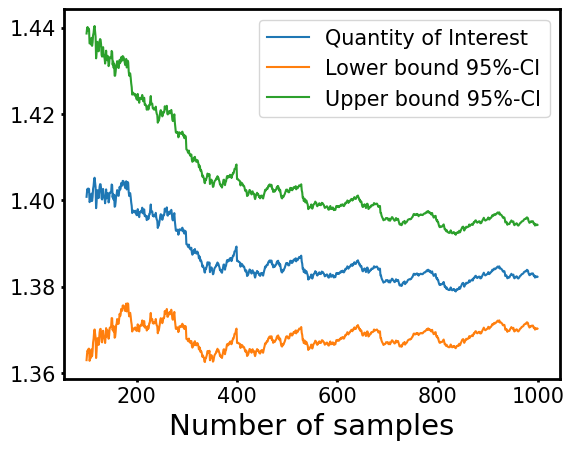

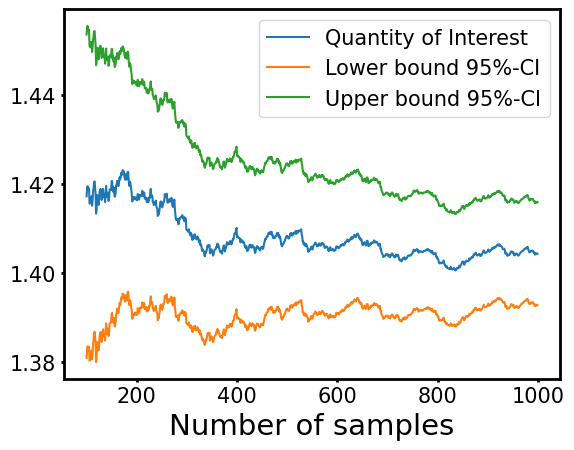

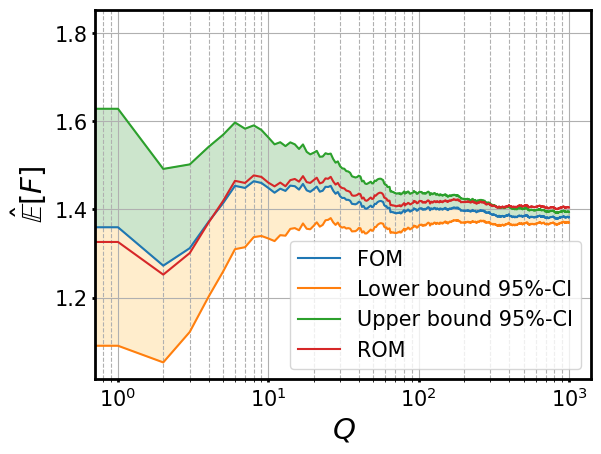

In [22]:
QoI_iter_FOM, QoI_confidence_95_low_iter_FOM, QoI_confidence_95_high_iter_FOM = Monte_Carlo(OoI_array_FOM, nsamples, 1)
QoI_iter_ROM, QoI_confidence_95_low_iter, QoI_confidence_95_high_iter = Monte_Carlo(OoI_array_ROM, nsamples, 1)

xaxis = np.arange(0,nsamples)

fig = plt.plot(xaxis,QoI_iter_FOM, label='FOM')
plt.plot(xaxis, QoI_confidence_95_low_iter_FOM, label='Lower bound 95%-CI')

plt.fill_between(xaxis, QoI_iter_FOM, QoI_confidence_95_high_iter_FOM, color= 'green', alpha=0.2)
plt.fill_between(xaxis, QoI_confidence_95_low_iter_FOM, QoI_iter_FOM, color= 'orange', alpha=0.2)
plt.plot(xaxis, QoI_confidence_95_high_iter_FOM, label='Upper bound 95%-CI')

plt.plot(xaxis, QoI_iter_ROM, label='ROM')
plt.ylabel('$\hat{\mathbb{E}}[F]$')
plt.xlabel('$Q$')

plt.xscale('log')

plt.grid(True, which='major', linestyle='-')
plt.grid(True, which='minor', linestyle='--')

legend = plt.legend()
plt.savefig('convergence2.png', bbox_inches='tight')


# PDF estimation

## Run Q samples, then randomly select M samples K times

In [23]:
Q = 50000
nsamples = Q

%run MC_Simulations_ROM.ipynb

QoI_array = np.zeros((Q))
for q in range(Q):
    print('iteration',q, end="\r")

    mu_test = mu[q]
    
    # Determine reduced vector on the interface
    u_I_pred = uI_model4(torch.from_numpy(mu_test).float()).detach().numpy()

    # Determine the reduced vector on domain 2
    u_2_pred = []

    # Loop through the number of modes on domain 2
    for i in range(int(cutoff2/nmodes)):

        mode2 = u_2_models34[i](torch.from_numpy(np.hstack((u_I_pred,mu_test[4]))).float()).detach().numpy()
        u_2_pred.append(mode2[0])

    u_2_predh = np.matmul(V_2,u_2_pred)
    u_I_predh = np.matmul(V_I,u_I_pred)
    
    QoI = np.mean(u_2_predh)
    QoI_array[q] = QoI

In [24]:
K = 30000
M = 4000

kQoI_array = np.zeros((K))
for ki in range(K):
    
    print('iteration',ki, end="\r")
    random.seed(ki)

    mQoI = 0
    for m in range(M):
        
        idx = int(random.uniform(0,M))

        mQoI += QoI_array[idx]
        
    mQoI = mQoI/M
    kQoI_array[ki] = mQoI


0.00031016805526480065


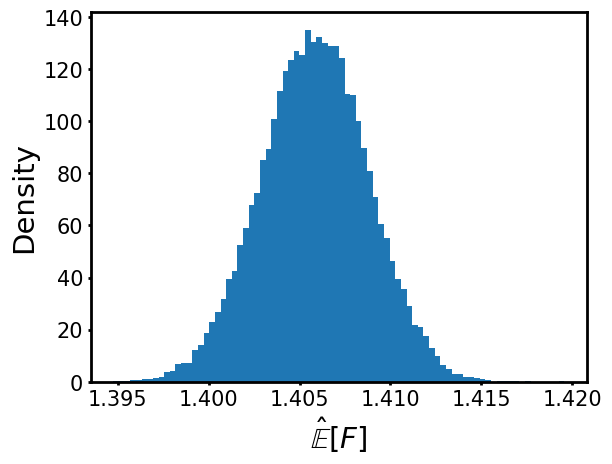

In [25]:
bins = 80

min_ROM = min(kQoI_array)
max_ROM = max(kQoI_array)

delta_ROM = (max_ROM-min_ROM)/bins
print(delta_ROM)

# Plots
barheights_ROM, bins_ROM, patches_ROM = plt.hist(kQoI_array, bins=bins, density='True') # make bins smaller

# ys = (barheights_ROM/sum(barheights_ROM))/delta_ROM
# xs = bins_ROM[:-1]
# plt.plot(xs,ys,'-',label='$f_{ROM}(x_i)$')
# plt.title('PDF estimation of $\mathbb{E}[F]$', fontsize='20')
xlabel = plt.xlabel('$\hat{\mathbb{E}}[F]$')
ylabel = plt.ylabel('Density')
plt.savefig('pdf', bbox_inches='tight')

plt.show()